In [1]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import cv2
from PIL import Image
from glob import glob
import skimage.io as io
import shutil

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor

In [2]:
current_path = os.getcwd()
converted_path = current_path.replace('/', '\\')
print(converted_path)

\home\duong\git\DecodeItAll\bio_seman_seg\unet\sessile-main-Kvasir-SEG


In [3]:
bio_seg_dir = "/".join(converted_path.split("\\")[:-2])
print(bio_seg_dir)
print(os.path.exists(bio_seg_dir))

/home/duong/git/DecodeItAll/bio_seman_seg
True


In [4]:
data_dir = bio_seg_dir + "/dataset/sessile-main-Kvasir-SEG"
print(os.listdir(data_dir))

['text_data', '.ipynb_checkpoints', 'masks', 'images']


# Split data

In [5]:
def create_text_file(data_dict, data_type, img_txt_path, mask_txt_path = None):
    
    with open(img_txt_path, 'w') as f:
        with open(mask_txt_path, 'w') as i:
            for key, value in data_dict.items():
                f.write(value[0])
                i.write(value[1])

                f.write("\n")
                i.write("\n")
                
    print("\n\n{0} files created.\nImages: {1}\nMasks: {2}".format(data_type.capitalize(), img_txt_path, mask_txt_path))
    return

def split_data(data_direct, seed, split_ratio = [.80, .20]):
    img_dir = os.path.join(data_direct, "images")
    mask_dir = os.path.join(data_direct, "masks")
    
    data_dict = {}
    for image in os.listdir(img_dir):
        img_path = os.path.join(img_dir, image)
        mask_path = os.path.join(mask_dir, image)
        data_dict[image] = [img_path, mask_path]

    # Random Seed
    random.seed(random_seed)
    data_list = list(data_dict.items())
    random.shuffle(data_list)
    
        
    # Data split
    train_size = int(len(data_list)*split_ratio[0])
    test_size = len(data_list) - train_size

    train_dict = dict(data_list[:train_size])
    test_dict = dict(data_list[train_size:])
    
    return train_dict, test_dict

data_direct = "text_data"
os.makedirs(data_direct, exist_ok=True)
random_seed = 42
split_ratio = [.80, .20]

train_dict, test_dict = split_data(data_dir, random_seed, split_ratio)

train_img_txt = "text_data/train_images.txt"
train_mask_txt = "text_data/train_masks.txt"

test_img_txt = "text_data/test_images.txt"
test_mask_txt = "text_data/test_masks.txt"

create_text_file(train_dict, "train", train_img_txt, train_mask_txt)
create_text_file(test_dict, "test", test_img_txt, test_mask_txt)

new_data = shutil.move(data_direct, bio_seg_dir + "/dataset/sessile-main-Kvasir-SEG")



Train files created.
Images: text_data/train_images.txt
Masks: text_data/train_masks.txt


Test files created.
Images: text_data/test_images.txt
Masks: text_data/test_masks.txt


In [6]:
new_data = bio_seg_dir + "/dataset/sessile-main-Kvasir-SEG/text_data"
print(os.listdir(new_data))

['test_masks.txt', '.ipynb_checkpoints', 'test_images.txt', 'train_masks.txt', 'train_images.txt']


In [7]:
def count_lines_in_files(file_paths):
    result = {}
    for file_path in file_paths:
        with open(file_path, 'r') as file:
            lines = file.readlines()
            num_lines = len(lines)
            result[file_path] = num_lines
    return result

# List of paths to files to count
file_paths = [new_data + '/train_images.txt', 
              new_data + '/test_images.txt', 
              new_data + '/train_masks.txt',
              new_data + '/test_masks.txt']

# Calculate len
line_counts = count_lines_in_files(file_paths)

# Print
for file_path, line_count in line_counts.items():
    print(f"Lines in {file_path}: {line_count}")


Lines in /home/duong/git/DecodeItAll/bio_seman_seg/dataset/sessile-main-Kvasir-SEG/text_data/train_images.txt: 156
Lines in /home/duong/git/DecodeItAll/bio_seman_seg/dataset/sessile-main-Kvasir-SEG/text_data/test_images.txt: 40
Lines in /home/duong/git/DecodeItAll/bio_seman_seg/dataset/sessile-main-Kvasir-SEG/text_data/train_masks.txt: 156
Lines in /home/duong/git/DecodeItAll/bio_seman_seg/dataset/sessile-main-Kvasir-SEG/text_data/test_masks.txt: 40


# Custom Dataset

In [51]:
class PolypDataset(Dataset):
    def __init__(self, data_file, label_file, input_size):
        with open(data_file) as f:
            self.image_paths = f.readlines()
        f.close()
        
        with open(label_file) as f:
            self.label_paths = f.readlines()
        f.close()

        self.image_paths = [x.strip() for x in self.image_paths]
        self.label_paths = [x.strip() for x in self.label_paths]
        
        self.input_size = input_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        label = io.imread(self.label_paths[idx])
        label = self.target_transform()(label)

        img = io.imread(self.image_paths[idx])
        img = self.transform()(img)
        return (img, label)
    def transform(self):
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(self.input_size, Image.BILINEAR),
            transforms.ToTensor(),
            #transforms.Normalize((0.4, 0.4, 0.4), (0.4, 0.4, 0.4))
            ])
    def target_transform(self):
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(self.input_size, Image.BILINEAR),
            transforms.Grayscale(num_output_channels = 1),
            transforms.ToTensor()
            ])    

156


/tmp/ipykernel_829904/3893381428.py:36: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  transforms.Resize(self.input_size, Image.BILINEAR),
/tmp/ipykernel_829904/3893381428.py:29: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  transforms.Resize(self.input_size, Image.BILINEAR),


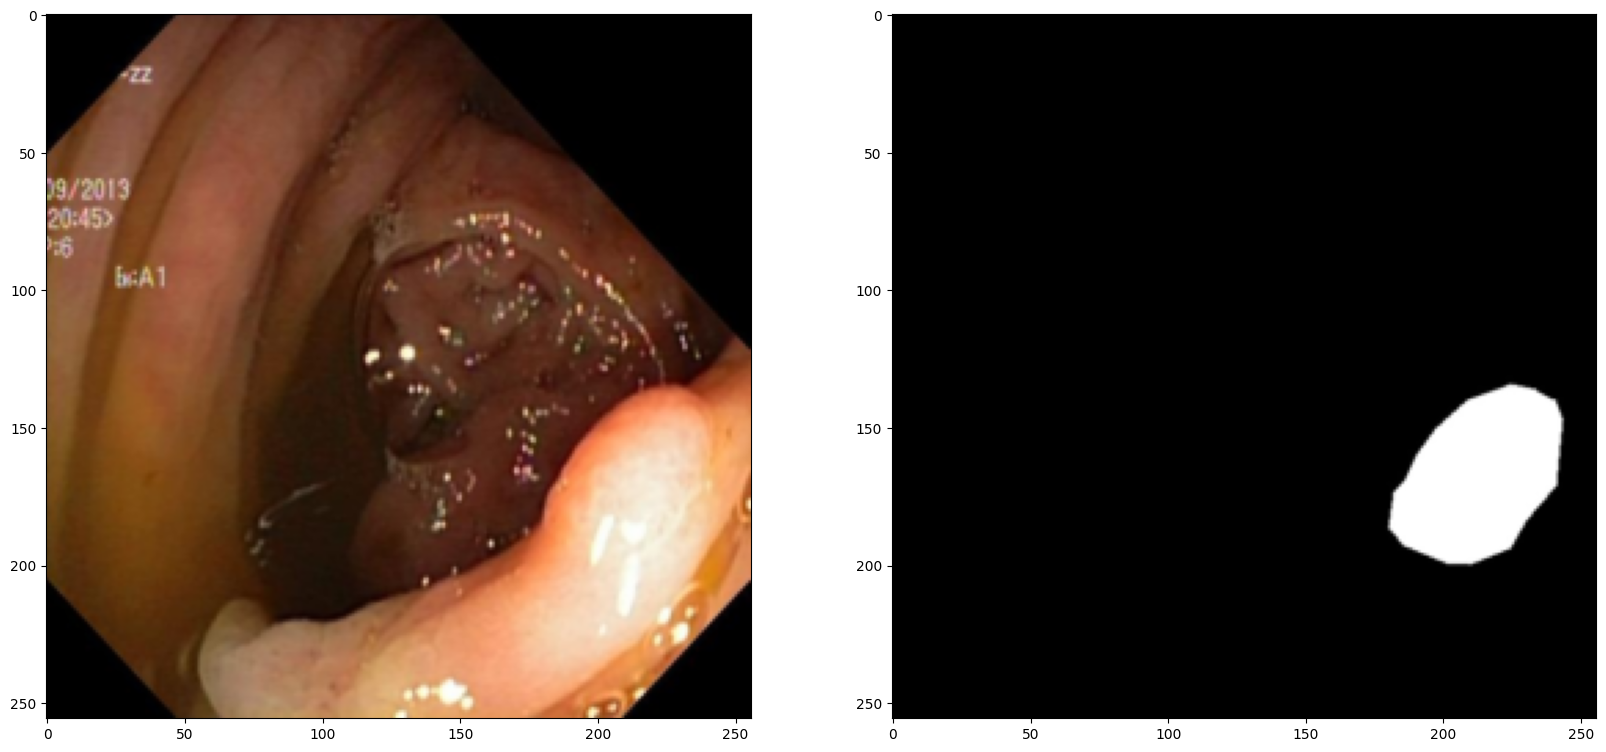

In [52]:
# Input size for model
input_size = (256, 256)

# Create train sets
train_images_file = new_data + '/train_images.txt'
train_labels_file = new_data + '/train_masks.txt'

train_ds = PolypDataset(train_images_file, train_labels_file, input_size)

print(len(train_ds))

img, msk = train_ds[0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))

ax1.imshow(img.permute(1, -1, 0).numpy())
ax2.imshow(msk.permute(1, -1, 0).numpy(), cmap = 'gray')

# DataLoader

In [53]:
train_dl = DataLoader(train_ds, batch_size=20, shuffle=True)

print(len(train_dl))

8
